In [188]:
import numpy as np
import math

import pandas as pd
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 500)
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.stats import f_oneway

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

## Reading data

In [189]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [190]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [191]:
categorical_features = df_train.dtypes[df_train.dtypes == "object"].index
numeric_features = df_train.dtypes[df_train.dtypes != "object"].index

## Handling Missing Values
Calculating the number and percentage of missing values in each column can give us a good idea of how they can be treated. 

In [192]:
total = df_train.isnull().sum()
percentage = (df_train.isnull().sum()/df_train.isnull().count() *100)
dtype = df_train.dtypes
nulls = pd.concat([total,percentage,dtype],axis = 1, keys=["Total", 'Percentage','Type']).sort_values(['Total'], ascending=False)
display(nulls)

,Total,Percentage,Type
PoolQC,1453,99.520548,object
MiscFeature,1406,96.301370,object
Alley,1369,93.767123,object
Fence,1179,80.753425,object
FireplaceQu,690,47.260274,object
LotFrontage,259,17.739726,float64
GarageYrBlt,81,5.547945,float64
GarageCond,81,5.547945,object
GarageType,81,5.547945,object
GarageFinish,81,5.547945,object


PoolQC seems to have the most missing values. Looking at the unique figures in the column we can tell that the null figures mean there is no pool present. The null values can therefore be replaced with 'None' to replresent this information.

In [193]:
df_train['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [194]:
df_train['PoolQC'].fillna(value="None", inplace = True)

Similarly, missing values in the following can also be replaced by 'None' indicating the feature does not exist.

In [195]:
print(df_train['MiscFeature'].unique())
print(df_train['Alley'].unique())
print(df_train['Fence'].unique())
print(df_train['FireplaceQu'].unique())

[nan 'Shed' 'Gar2' 'Othr' 'TenC']
[nan 'Grvl' 'Pave']
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']


In [196]:
df_train['MiscFeature'].fillna(value="None", inplace = True)
df_train['Alley'].fillna(value="None", inplace = True)
df_train['Fence'].fillna(value="None", inplace = True)
df_train['FireplaceQu'].fillna(value="None", inplace = True)

All garage features have the same number of missing values indicating yje houses do not have garages and therefore can also be replaces with 'None'

In [197]:
print(df_train['GarageType'].unique())
print(df_train['GarageFinish'].unique())
print(df_train['GarageQual'].unique())
print(df_train['GarageCond'].unique())

print(df_train['GarageType'].isnull().sum())
print(df_train['GarageFinish'].isnull().sum())
print(df_train['GarageQual'].isnull().sum())
print(df_train['GarageCond'].isnull().sum())

['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
['RFn' 'Unf' 'Fin' nan]
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
81
81
81
81


In [198]:
df_train['GarageType'].fillna(value="None", inplace = True)
df_train['GarageFinish'].fillna(value="None", inplace = True)
df_train['GarageQual'].fillna(value="None", inplace = True)
df_train['GarageCond'].fillna(value="None", inplace = True)

GarageYrBlt has the same number of missing values as the other garage features indicating they belong to the houses with no garage. However, this is a numerical feature and therefore the missing values will have to be replaced with a numerical value. It makes sense to replace null values with the YearBuilt values as garage would probably be built at the same time as the house itself. The non-existence of the garage can be penalised by the model with other features.

In [199]:
print(df_train['GarageYrBlt'].isnull().sum())

81


In [200]:
df_train['GarageYrBlt'].fillna(df_train['YearBuilt'], inplace=True)

In [201]:
print(df_train['BsmtQual'].unique())
print(df_train['BsmtCond'].unique())
print(df_train['BsmtExposure'].unique())
print(df_train['BsmtFinType1'].unique())
print(df_train['BsmtFinType2'].unique())

print(df_train['BsmtQual'].isnull().sum())
print(df_train['BsmtCond'].isnull().sum())
print(df_train['BsmtExposure'].isnull().sum())
print(df_train['BsmtFinType1'].isnull().sum())
print(df_train['BsmtFinType2'].isnull().sum())

['Gd' 'TA' 'Ex' nan 'Fa']
['TA' 'Gd' nan 'Fa' 'Po']
['No' 'Gd' 'Mn' 'Av' nan]
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
37
37
38
37
38


In [202]:
df_train['BsmtExposure'].fillna(value="None", inplace = True)
df_train['BsmtFinType1'].fillna(value="None", inplace = True)
df_train['BsmtFinType2'].fillna(value="None", inplace = True)
df_train['BsmtQual'].fillna(value="None", inplace = True)
df_train['BsmtCond'].fillna(value="None", inplace = True)

In [203]:
print(df_train['MasVnrType'].unique())

print(df_train['MasVnrType'].isnull().sum())
print(df_train['MasVnrArea'].isnull().sum())

['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
8
8


In [204]:
df_train['MasVnrType'].fillna(value="None", inplace = True)
df_train['MasVnrArea'].fillna(value=0, inplace=True)

In [205]:
print(df_train['Electrical'].unique())
print(df_train['Electrical'].isnull().sum())

['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
1


All houses have an electical system and therefore missing values will be replaced with the modeof the column.

In [206]:
df_train['Electrical'].fillna(df_train['Electrical'].mode()[0], inplace=True)

LotFrontage is a continuous numerical feature and therefore missing values are replaced with the median

In [207]:
df_train['LotFrontage'].fillna(df_train['LotFrontage'].median(), inplace=True)

In [208]:
df_train.isnull().sum().sum()

0

No more missing values remain. We can now move on to prepare some of the ordinal features for the model.

## Handling Ordinal Features

Many of the features available indicate quality or condition. These ordinal features can be mapped with numerical values based on their relative desirability; 0 being least desirable.

In [209]:
df_train['PoolQC'] = df_train['PoolQC'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['GarageCond'] = df_train['GarageCond'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['GarageFinish'] = df_train['GarageFinish'].map({"None":0, 'Unf':1, 'RFn':2, 'Fin':3})
df_train['FireplaceQu'] = df_train['FireplaceQu'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['GarageQual'] = df_train['GarageQual'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['BsmtExposure'] = df_train['BsmtExposure'].map({"None":0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].map({"None":0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].map({"None":0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df_train['BsmtQual'] = df_train['BsmtQual'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['BsmtCond'] = df_train['BsmtCond'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['ExterQual'] = df_train['ExterQual'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['ExterCond'] = df_train['ExterCond'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['HeatingQC'] = df_train['HeatingQC'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['KitchenQual'] = df_train['KitchenQual'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

The following features can also be mapped similarly as it is apparent which features are more expensive and desirable.

In [210]:
df_train['Alley'] = df_train['Alley'].map({"None":0, "Grvl":1, 'Pave':2})
df_train['Street'] = df_train['Street'].map({"Grvl":0, 'Pave':1})
df_train['CentralAir'] = df_train['CentralAir'].map({"N":0, 'Y':1})
df_train['PavedDrive'] = df_train['PavedDrive'].map({"N":0, 'P':1, 'Y':2})
df_train['LandSlope'] = df_train['LandSlope'].map({"Sev":0, 'Mod':1, 'Gtl':2})

The neighborhoods be classified as rich: 2, mid: 1 and poor: 0. This can be determined by looking at the median prices in each neighborhood. The quartiles of the SalePrice can then be used to classify the neighborhoods.

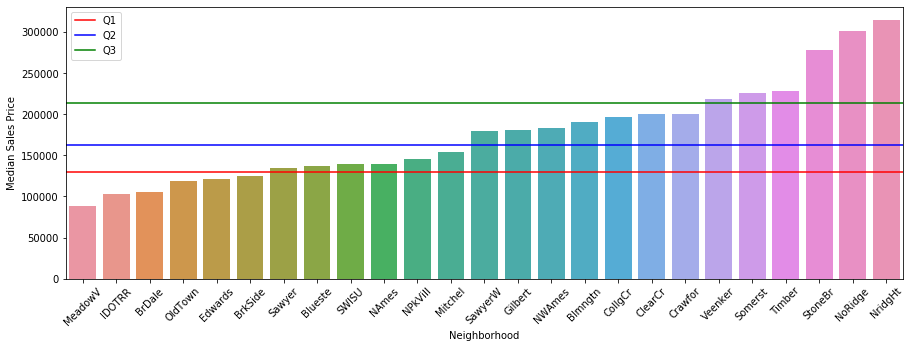

In [211]:
median_prices = df_train.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=True)
neighborhoods = median_prices.index

Q1 = df_train['SalePrice'].describe()['25%']
Q2 = df_train['SalePrice'].describe()['50%']
Q3 = df_train['SalePrice'].describe()['75%']

plt.figure(figsize=[15,5])
ax = sns.barplot(y = median_prices, x = neighborhoods)
plt.xticks(rotation=45)
plt.xlabel('Neighborhood')
plt.ylabel('Median Sales Price')
plt.axhline(y=Q1, color='r', linestyle='-', label='Q1')
plt.axhline(y=Q2, color='b', linestyle='-', label='Q2')
plt.axhline(y=Q3, color='g', linestyle='-', label='Q3')
plt.legend()

plt.show()

In [212]:
neghborhood_map = {}
for neighborhood in neighborhoods:
    if median_prices[neighborhood] <= Q1:
        neghborhood_map[neighborhood] = 0
    elif median_prices[neighborhood] >= Q3:
        neghborhood_map[neighborhood] = 2
    else:
        neghborhood_map[neighborhood] = 1 

df_train['Neighborhood'] = df_train['Neighborhood'].map(neghborhood_map)

In [213]:
numeric_features = df_train.dtypes[df_train.dtypes != "object"].index

## Converting Features from numeric to categoric

Some numeric features are not directly proportional to SalesPrice. A house sold later may not necessarily be priced higher. These fatures will have to be categorized.

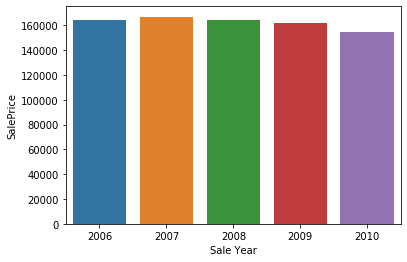

In [214]:
sns.barplot(y = df_train.groupby('YrSold')['SalePrice'].median(), x = df_train['YrSold'].unique())
plt.xlabel('Sale Year')
plt.show()

df_train['YrSold'] = df_train['YrSold'].astype(object)


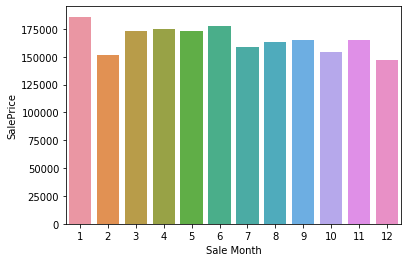

In [215]:
sns.barplot(y = df_train.groupby('MoSold')['SalePrice'].median(), x = df_train['MoSold'].unique())
plt.xlabel('Sale Month')
plt.show()

df_train['MoSold'] = df_train['MoSold'].astype(object)

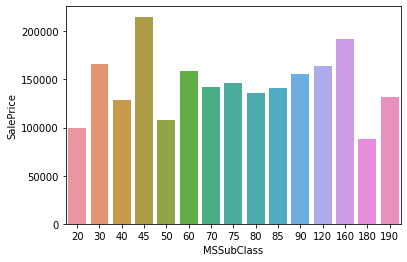

In [216]:
sns.barplot(y = df_train.groupby('MSSubClass')['SalePrice'].median(), x = df_train['MSSubClass'].unique())
plt.xlabel('MSSubClass')
plt.show()

df_train['MSSubClass'] = df_train['MSSubClass'].astype(object)

In [217]:
categorical_features = df_train.dtypes[df_train.dtypes == "object"].index

## Creating new features

New features can be created to extract more information from the data and consequently drop features that may not be very helpful.

The age of the house can be calculated as the time between when it was remodelled and the year it was sold. If no remodelling was done, YearRemodAdd = YearBuilt. A new feature can also be added to indicate whether or not a house was remodelled to ensure that information is not lost. Additionally another feature can indicate if a house is brand new.

In [218]:
df_train[['YearRemodAdd','YearBuilt']].head()

,YearRemodAdd,YearBuilt
0,2003,2003
1,1976,1976
2,2002,2001
3,1970,1915
4,2000,2000


In [219]:
df_train['Age'] = (df_train['YearRemodAdd'] - df_train['YrSold']).astype(int)
df_train['Remoded'] = (df_train['YearRemodAdd'] - df_train['YearBuilt'] != 0).map({False:0, True:1})
df_train['IsNew'] = (df_train['YearBuilt'] == df_train['YrSold']).map({False:0, True:1})

TotalArea and TotBath can help incorporate data from several feautures which individually may not tell us a whole lot.

In [220]:
df_train['TotalArea'] = (df_train['GarageArea']
                         + df_train['GrLivArea'] + df_train['TotalBsmtSF'])      

df_train['TotBath'] = (df_train['FullBath'] + df_train['HalfBath']*0.5 
                        + df_train['BsmtFullBath'] + df_train['BsmtHalfBath']*0.5)

Several features can now be eliminated as they are used to create new features

In [221]:
df_train = df_train.drop('FullBath',1)
df_train = df_train.drop('HalfBath',1)
df_train = df_train.drop('YearBuilt',1)
df_train = df_train.drop('YearRemodAdd',1)
df_train = df_train.drop('Id',1)
df_train = df_train.drop('GrLivArea',1)
df_train = df_train.drop('TotalBsmtSF',1)
df_train = df_train.drop('GarageArea',1)
df_train = df_train.drop('BsmtFullBath',1)
df_train = df_train.drop('BsmtHalfBath',1)

In [222]:
numeric_features = df_train.dtypes[df_train.dtypes != "object"].index

## Feature correlation

We can now take a look at how these numeric features correlate with SalePrice

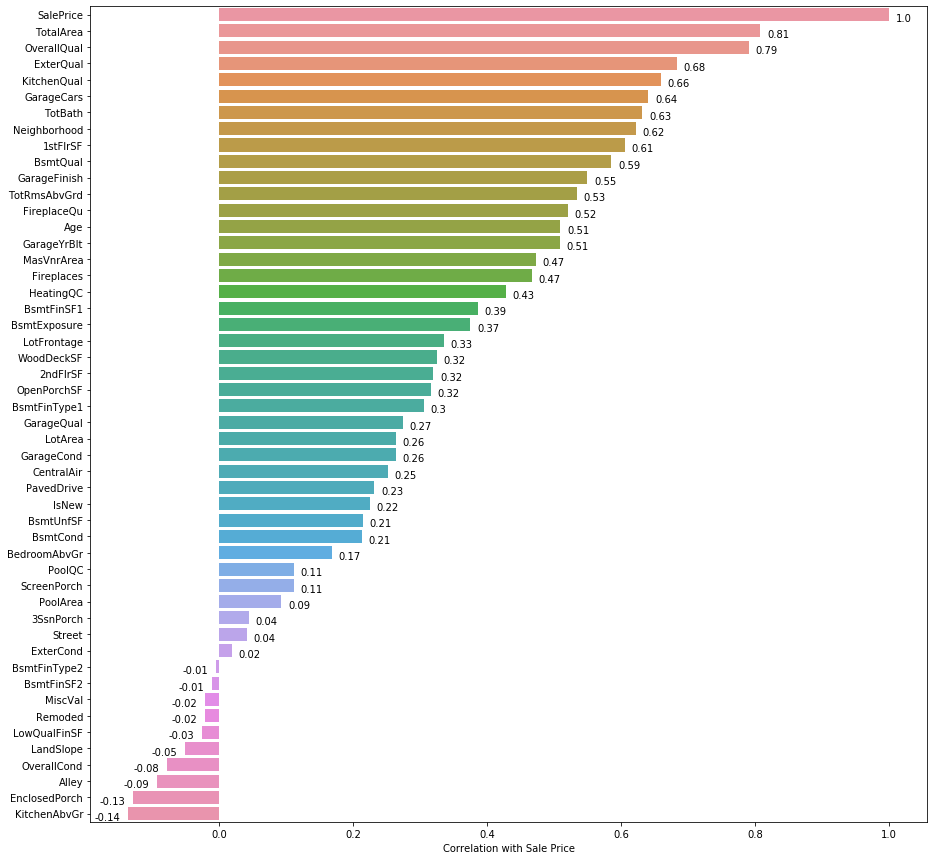

In [223]:
corr_matrix = df_train.corr()
corr_matrix = corr_matrix['SalePrice'].sort_values(ascending=False)
strong_attributes = [i for i in corr_matrix.index if (corr_matrix.loc[i] >= 0.5 or corr_matrix.loc[i] <= -0.5) and i != 'SalePrice']
attributes = corr_matrix.drop('SalePrice').index

plt.figure(figsize=[15,15])
ax = sns.barplot(y = corr_matrix.index, x = corr_matrix)
plt.xlabel('Correlation with Sale Price')

for p in ax.patches:
    if p.get_width() > 0:
        _x = p.get_x() + p.get_width() + float(0.01)
    else:
        _x = p.get_x() + p.get_width() - float(0.05)
    _y = p.get_y() + p.get_height()
    value = round(float(p.get_width()),2)
    ax.text(_x, _y, value, ha="left")
        
plt.show()

We can use a heatmap to look at intercorrelation between strong features to ensure they are not too high.

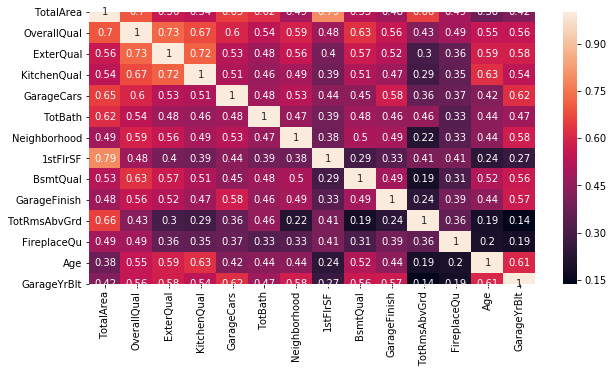

In [224]:
plt.figure(figsize=[10,5])
sns.heatmap(df_train[strong_attributes].corr(), annot=True)
plt.show()

## Feature Importance

In [225]:
categorical_features

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType',
       'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [226]:
numeric_features

Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'LandSlope',
       'Neighborhood', 'OverallQual', 'OverallCond', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'HeatingQC',
       'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'MiscVal', 'SalePrice', 'Age', 'Remoded', 'IsNew', 'TotalArea',
       'TotBath'],
      dtype='object')

In [106]:
F = f_oneway(df_train['SalePrice'].loc[df_train['YrSold'] == '2006'],
             df_train['SalePrice'].loc[df_train['YrSold'] == '2007'],
            df_train['SalePrice'].loc[df_train['YrSold'] == '2008'],
            df_train['SalePrice'].loc[df_train['YrSold'] == '2009'],
            df_train['SalePrice'].loc[df_train['YrSold'] == '2010'])
F

F_onewayResult(statistic=nan, pvalue=nan)

In [227]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

X = df_train[numeric_features].drop('SalePrice',1)
y = df_train['SalePrice']

forest = ExtraTreesClassifier(n_estimators=400,
                              random_state=10)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


In [228]:
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

Feature ranking:
1. feature LotFrontage (0.049202)
2. feature LotArea (0.046911)
3. feature Street (0.045828)
4. feature Alley (0.044421)
5. feature LandSlope (0.043812)
6. feature Neighborhood (0.043658)
7. feature OverallQual (0.043635)
8. feature OverallCond (0.038050)
9. feature MasVnrArea (0.036252)
10. feature ExterQual (0.035448)
11. feature ExterCond (0.034268)
12. feature BsmtQual (0.031000)
13. feature BsmtCond (0.030681)
14. feature BsmtExposure (0.030612)
15. feature BsmtFinType1 (0.029335)
16. feature BsmtFinSF1 (0.028680)
17. feature BsmtFinType2 (0.026581)
18. feature BsmtFinSF2 (0.025479)
19. feature BsmtUnfSF (0.025223)
20. feature HeatingQC (0.024633)
21. feature CentralAir (0.023697)
22. feature 1stFlrSF (0.020947)
23. feature 2ndFlrSF (0.019795)
24. feature LowQualFinSF (0.018606)
25. feature BedroomAbvGr (0.017783)
26. feature KitchenAbvGr (0.017618)
27. feature KitchenQual (0.016726)
28. feature TotRmsAbvGrd (0.016178)
29. feature Fireplaces (0.013420)
30. feature

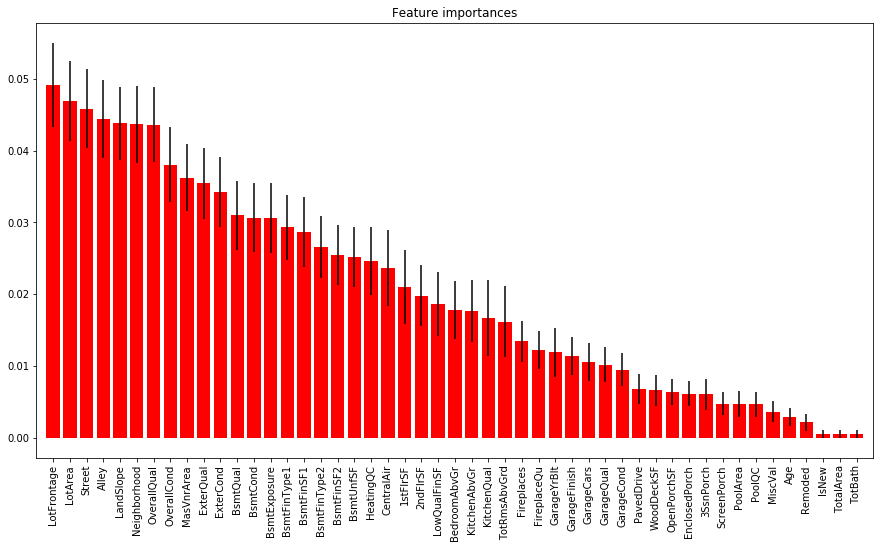

In [229]:
plt.figure(figsize=[15,8])
plt.title("Feature importances")
plt.bar(X.columns, importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## OneHot Encoding Categoric Features

In [230]:
ohe = OneHotEncoder()

def OHEncode(feature):
    tranformed = ohe.fit_transform(df_train[[feature]]).toarray()
    tranformed_df = pd.DataFrame(tranformed, columns = ohe.categories_[0])
    
    for column in tranformed_df.columns:
        if tranformed_df[column].sum() <= 10:
            tranformed_df = tranformed_df.drop(column, axis=1)
   
    return tranformed_df

    
df_train = pd.concat([df_train,OHEncode('YrSold')], axis =1)
df_train = df_train.drop('YrSold', 1)
df_train = pd.concat([df_train,OHEncode('MoSold')], axis =1)
df_train = df_train.drop('MoSold', 1)
df_train = pd.concat([df_train,OHEncode('MiscFeature')], axis =1)
df_train = df_train.drop('MiscFeature', 1)
df_train = pd.concat([df_train,OHEncode('MSZoning')], axis =1)
df_train = df_train.drop('MSZoning', 1)
df_train = pd.concat([df_train,OHEncode('SaleCondition')], axis =1)
df_train = df_train.drop('SaleCondition', 1)


## Dealing with skewness

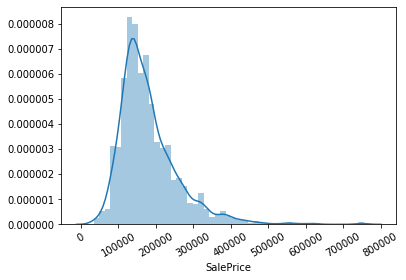

In [231]:
sns.distplot(df_train['SalePrice'])
plt.xticks(rotation=30)
plt.show()

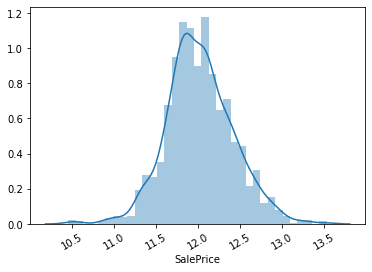

In [232]:
sns.distplot(df_train['SalePrice'].apply(lambda x: math.log(x)))
plt.xticks(rotation=30)
plt.show()

In [242]:
for feature in numeric_features:
    if df_train[feature].skew() > 0.8:
        df_train[feature] = df_train[feature].apply(lambda x: math.log(x + 1))
    
df_train['SalePrice'] = df_train['SalePrice'].apply(lambda x: math.log(x))

numeric_features = df_train.dtypes[df_train.dtypes != "object"].index.drop('SalePrice')
data = preprocessing.scale(df_train[numeric_features])

In [243]:
train_data = data
train_labels = df_train['SalePrice']

data_train, data_test, labels_train, labels_test = train_test_split(train_data, train_labels, test_size=0.20, random_state=42)

In [164]:
# for feature in categorical_features:
#     plt.figure(figsize=[8,8])
#     df_train.groupby(feature)['SalePrice'].median().plot.bar()
# #     plt.bar(df_train[feature], df_train['SalePrice'])
#     plt.xlabel(feature)
#     plt.ylabel('Sale Price')
#     plt.show()

In [244]:
model = linear_model.LinearRegression()

model.fit(data_train, labels_train)

pred = model.predict(data_test)

print(np.sqrt(mean_squared_error(labels_test, pred)))
print(r2_score(labels_test, pred))

0.004742759027764694
0.911611018624609


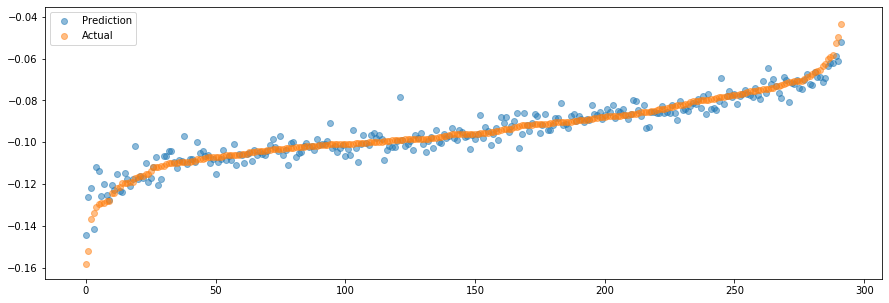

In [245]:
df = pd.DataFrame(list(zip(labels_test,pred)), columns=['SalePrice', 'Pred'])
df = df.sort_values('SalePrice',ascending=True).reset_index()


plt.figure(figsize=[15,5])
plt.scatter(df.index,df['Pred'], alpha = 0.5, label = 'Prediction')
plt.scatter(df.index,df['SalePrice'], alpha = 0.5, label = 'Actual')
plt.legend()
plt.show()